<a href="https://colab.research.google.com/github/Mahesh-more1/Garbage-Classification/blob/main/Garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Based Garbage Classification System using EfficientNetV2B2
---------------

### <span style="color:red">**1 - Setup**</span><br>

#### <span style="color:red">**1.1 - Dataset Setup**</span><br>
Download the dataset from a public Google Drive link and extract it. No login is required as the file is publicly shared.


In [ ]:
!pip install gdown
!gdown --id 1mpSzWvcNvy3HqC2LLMN44MF0wIDBXZ0S -O Dataset.zip
import zipfile
import shutil
import os

zip_path = 'Dataset.zip'
extract_path = '/content/Dataset'

if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

dataset_dir = "/content/Dataset/Dataset"

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1mpSzWvcNvy3HqC2LLMN44MF0wIDBXZ0S
From (redirected): https://drive.google.com/uc?id=1mpSzWvcNvy3HqC2LLMN44MF0wIDBXZ0S&confirm=t&uuid=da5fcfe4-6f3d-42e6-84ed-c6541b580632
To: /content/Dataset.zip
100% 42.9M/42.9M [00:00<00:00, 157MB/s]


#### <span style="color:red">**1.2 - Importing Libraries**</span><br>
This section includes all essential libraries required for data preprocessing, visualization, model building, evaluation, and deployment.

1. **`os`** – for handling file paths, directories, and system-level operations  
2. **`numpy`** – for efficient numerical operations and array manipulations  
3. **`matplotlib.pyplot`** – for plotting graphs and visualizing training metrics  
4. **`seaborn`** – for enhanced statistical data visualizations (heatmaps, etc.)  
5. **`tensorflow`** – for building and training machine learning models  
6. **`keras`** – high-level API in TensorFlow used to simplify model architecture  
7. **`Sequential`** – to build models layer-by-layer in Keras  
8. **`layers`** – contains essential building blocks like Rescaling, Pooling, Dense, etc.  
9. **`optimizers` and `callbacks`** – for tuning model performance and training control  
10. **`Layer`** – for creating custom layers (if needed)  
11. **`EfficientNetV2B2`** – a pretrained model used for transfer learning  
12. **`compute_class_weight`** – handles class imbalance by computing weights  
13. **`confusion_matrix`, `classification_report`** – for model evaluation and diagnostics  
14. **`gradio`** – to build an interactive web interface for your trained model  
15. **`pickle`** – for saving and loading training history  

> ✅ These imports ensure that the project is fully equipped for preprocessing, training, evaluation, visualization, and deployment.


In [ ]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential, load_model  # Importing Sequential model and load_model for saving/loading
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models
import pickle  # Importing pickle for saving/loading training history

### <span style="color:red">**2 - Data Loading**</span><br>
Load the dataset using `image_dataset_from_directory` and split into training, validation, and test sets. The `dataset_dir` is set to the extracted location.


In [ ]:
# Loading Dataset
dataset_dir = r"/content/Dataset/Dataset"

image_size = (224, 224)
batch_size = 32
seed = 42

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Get class names from validation dataset
val_class = val_ds.class_names

# Split validation into test and validation sets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# ✨ Pretty output section
print("\nDataset Summary")
print("-" * 30)

print("Class Names:")
for i, cls in enumerate(train_ds.class_names, 1):
    print(f"  {i}. {cls}")

print(f"\nTotal Classes     : {len(train_ds.class_names)}")
print(f"Training Batches  : {len(train_ds)}")
print(f"Validation Batches: {len(val_dat)}")
print(f"Test Batches      : {len(test_ds)}")
print("-" * 30)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.

Dataset Summary
------------------------------
Class Names:
  1. cardboard
  2. glass
  3. metal
  4. paper
  5. plastic
  6. trash

Total Classes     : 6
Training Batches  : 64
Validation Batches: 8
Test Batches      : 8
------------------------------


### <span style="color:red">**3 - Data Exploration**</span><br>
Visualize one sample image from each class.


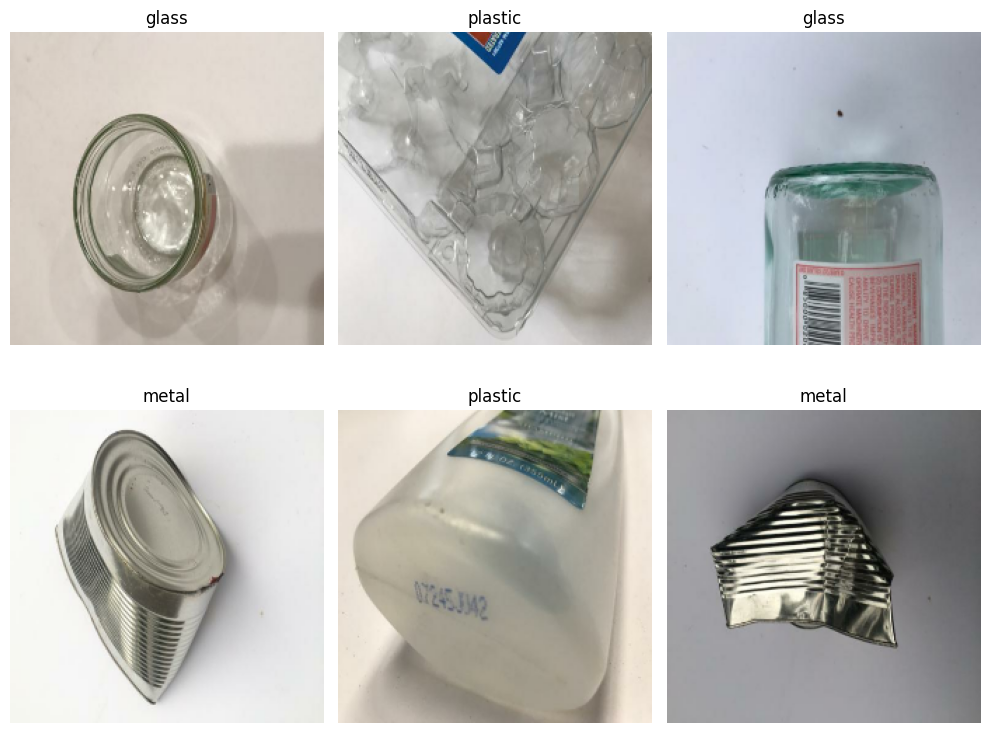

In [ ]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(min(6, len(images))):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()


#### <span style="color:red">**3.1 - Class Distribution Analysis**</span><br>
Analyze the distribution of classes across training, validation, and test sets using custom bar charts to assess data balance.

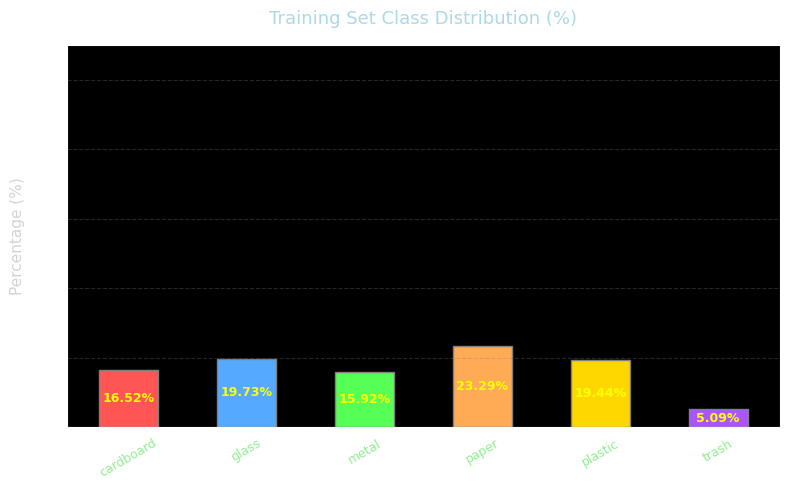

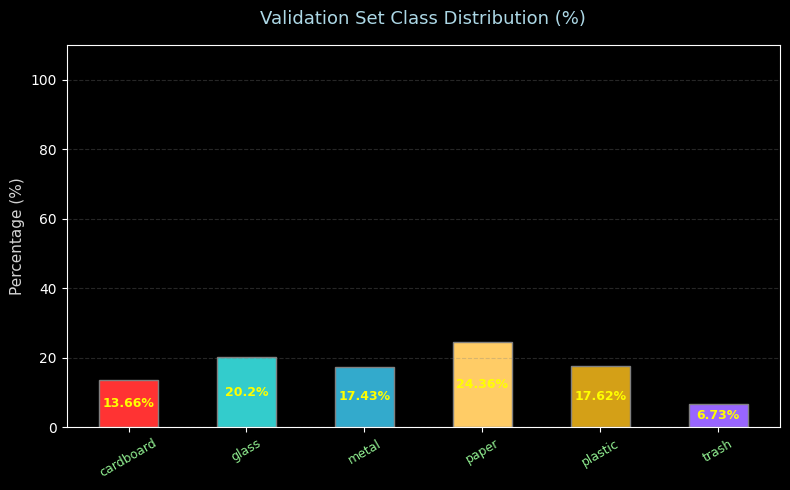

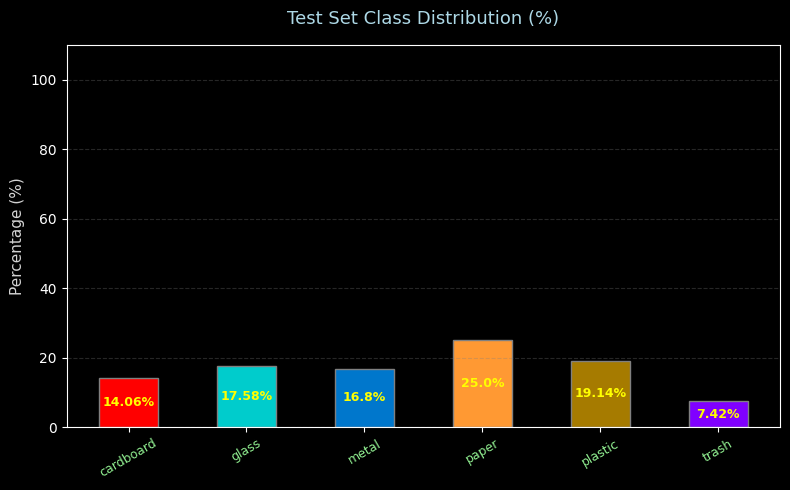

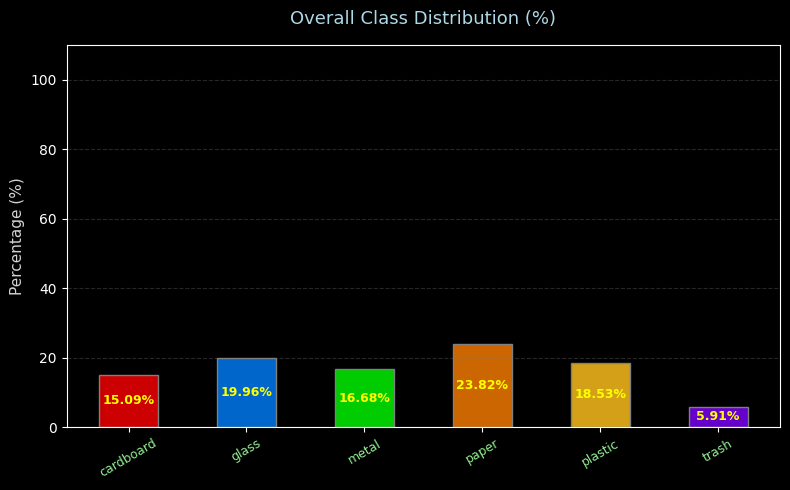

In [ ]:
# Function to count class distribution (in %)
def calculate_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            counts[class_names[label]] += 1
            total += 1

    return {k: round((v / total) * 100, 2) for k, v in counts.items()}

# Custom bar plot function with different styling
def custom_bar_plot(dist, title, colors):
    plt.figure(figsize=(8, 5))
    plt.style.use('dark_background')  # Changed to a valid built-in style

    bars = plt.bar(dist.keys(), dist.values(), color=colors, width=0.5, edgecolor='gray')

    # Add value labels inside bars with adjusted contrast
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height/2, f'{height}%',
                 ha='center', va='center', color='yellow', fontsize=9, fontweight='bold')

    plt.title(title, fontsize=13, pad=15, color='lightblue')
    plt.ylabel('Percentage (%)', fontsize=11, color='lightgray')
    plt.xticks(rotation=30, fontsize=9, color='lightgreen')
    plt.ylim(0, 110)
    plt.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    plt.tight_layout()
    plt.show()

# Get class names
class_names = train_ds.class_names

# Compute distributions
train_dist = calculate_distribution(train_ds, class_names)
val_dist = calculate_distribution(val_ds, class_names)
test_dist = calculate_distribution(test_ds, class_names)
overall_dist = {k: round((train_dist[k] + val_dist[k]) / 2, 2) for k in class_names}

# Define unique color palettes for each plot (adjusted for dark background)
train_colors = ['#FF5555', '#55AAFF', '#55FF55', '#FFAA55', '#FFD700', '#AA55FF']
val_colors = ['#FF3333', '#33CCCC', '#33AACC', '#FFCC66', '#D4A017', '#9966FF']
test_colors = ['#FF0000', '#00CCCC', '#0077CC', '#FF9933', '#A67B00', '#8000FF']
overall_colors = ['#CC0000', '#0066CC', '#00CC00', '#CC6600', '#D4A017', '#6600CC']

# Plot distributions with unique styles
custom_bar_plot(train_dist, "Training Set Class Distribution (%)", train_colors)
custom_bar_plot(val_dist, "Validation Set Class Distribution (%)", val_colors)
custom_bar_plot(test_dist, "Test Set Class Distribution (%)", test_colors)
custom_bar_plot(overall_dist, "Overall Class Distribution (%)", overall_colors)

### <span style="color:red">**4 - Data Preprocessing**</span><br>

#### <span style="color:red">**4.1 - Data Augmentation**</span><br>
Apply data augmentation to improve model robustness.


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

#### <span style="color:red">**4.2 - Class Weights**</span><br>
Compute class weights to address class imbalance and visualize class distribution.


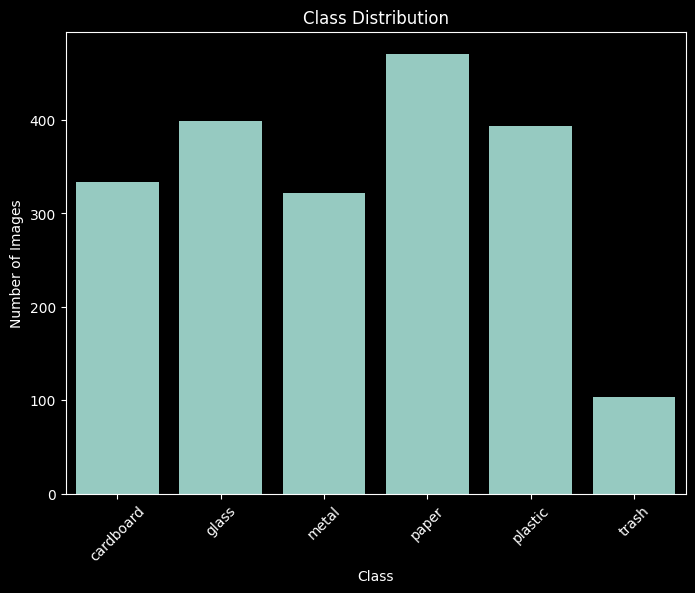

cardboard: 1.01
glass: 0.84
metal: 1.05
paper: 0.72
plastic: 0.86
trash: 3.27


In [ ]:
class_names = train_ds.class_names
labels = np.concatenate([labels.numpy() for _, labels in train_ds])

# Compute class counts using bincount, ensuring it matches class_names length
max_label = len(class_names) - 1
class_counts = np.bincount(labels, minlength=max_label + 1)[:len(class_names)]

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.arange(len(class_names)), y=labels
)
class_weight_dict = dict(enumerate(class_weights))

# Visualize class distribution with corrected lengths
plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

# Display class weights
for idx, weight in enumerate(class_weights):
    print(f"{class_names[idx]}: {weight:.2f}")

### <span style="color:red">**5 - Model Building**</span><br>
Construct the EfficientNetV2B2 model with a custom classification head. Input scaling is handled by `preprocess_input` in deployment.


In [ ]:
num_classes = len(class_names)

base_model = EfficientNetV2B2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### <span style="color:red">**6 - Model Training**</span><br>

#### <span style="color:red">**6.1 - Callbacks Setup**</span><br>
Define early stopping and learning rate reduction callbacks.


In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=0.00001
)
checkpoint = callbacks.ModelCheckpoint(
    "best_model_finetuned224.keras", monitor="val_accuracy", save_best_only=True, mode="max"
)

#### <span style="color:red">**6.2 - Initial Training**</span><br>
Train the model initially with the base model frozen.


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_dat,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weight_dict,
)

# Save initial training history
with open("history_initial224.pkl", "wb") as file:
    pickle.dump(history.history, file)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.5477 - loss: 1.2107 - val_accuracy: 0.8394 - val_loss: 0.4663 - learning_rate: 0.0010
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.8097 - loss: 0.5389 - val_accuracy: 0.8112 - val_loss: 0.4787 - learning_rate: 0.0010
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.8299 - loss: 0.4642 - val_accuracy: 0.8554 - val_loss: 0.4690 - learning_rate: 0.0010
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.8623 - loss: 0.3975 - val_accuracy: 0.8755 - val_loss: 0.3745 - learning_rate: 0.0010
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.8636 - loss: 0.3537 - val_accuracy: 0.8514 - val_loss: 0.4388 - learning_rate: 0.0010
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.8787 - loss: 0.3427 - val_accuracy: 0.8876 - val_loss: 0.3607 - learning_rate: 0.0010
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.8884 - loss: 0.3043 - val_acc

#### <span style="color:red">**6.3 - Fine-Tuning**</span><br>
Unfreeze the base model and fine-tune with a lower learning rate.


In [ ]:
base_model.trainable = True
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history_finetuned = model.fit(
    train_ds,
    validation_data=val_dat,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weight_dict,
)

# Save fine-tuned history
with open("history_finetuned224.pkl", "wb") as file:
    pickle.dump(history_finetuned.history, file)

### <span style="color:red">**7 - Evaluation**</span><br>

#### <span style="color:red">**7.1 - Evaluation Metrics**</span><br>
Evaluate the model and generate classification report using the best saved model.


In [ ]:
# Load the best saved model
model = load_model("best_model_finetuned224.keras")

test_loss, test_accuracy = model.evaluate(test_ds_eval)

y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_pred = np.argmax(model.predict(test_ds, verbose=0), axis=1)

print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")
print(classification_report(y_true, y_pred, target_names=class_names))

#### <span style="color:red">**7.2 - Confusion Matrix Preparation**</span><br>
Compute and prepare data for the confusion matrix.


In [ ]:
cm = confusion_matrix(y_true, y_pred)

### <span style="color:red">**8 - Visualization**</span><br>

#### <span style="color:red">**8.1 - Sample Images**</span><br>
Visualize one sample image from each class.


In [ ]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(min(6, len(images))):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()

#### <span style="color:red">**8.2 - Class Distribution**</span><br>
Visualize the distribution of classes.


In [ ]:
class_counts = np.bincount(labels)
plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

#### <span style="color:red">**8.3 - Training Curves**</span><br>
Plot training and validation accuracy/loss for both initial and fine-tuned models.


In [ ]:
# Plot initial training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Initial Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Initial Validation Accuracy")
plt.title("Initial Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Initial Training Loss")
plt.plot(history.history["val_loss"], label="Initial Validation Loss")
plt.title("Initial Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Plot fine-tuned training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_finetuned.history["accuracy"], label="Finetuned Training Accuracy")
plt.plot(history_finetuned.history["val_accuracy"], label="Finetuned Validation Accuracy")
plt.title("Finetuned Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_finetuned.history["loss"], label="Finetuned Training Loss")
plt.plot(history_finetuned.history["val_loss"], label="Finetuned Validation Loss")
plt.title("Finetuned Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

#### <span style="color:red">**8.4 - Confusion Matrix**</span><br>
Visualize the confusion matrix.


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### <span style="color:red">**9 - Deployment**</span><br>
Create an interactive interface for predicting garbage classes from images, aligned with reference styling.


In [ ]:
# Class labels (ensure consistency with training)
class_names = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

# Classify image and return top prediction with styled output
def classify_image(img):
    try:
        if img is None:
            return "<div style='color:red;'>No image received. Please upload or capture an image.</div>"

        img = img.resize((224, 224))
        img_array = np.array(img, dtype=np.float32)

        if img_array.shape != (224, 224, 3):
            return f"<div style='color:red;'>Unexpected input shape: {img_array.shape}</div>"

        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array, verbose=0)[0]

        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_names[predicted_class_index]
        confidence = float(prediction[predicted_class_index])

        # Return styled HTML result
        return f"""
        <div style='text-align: center; font-size: 28px; font-weight: bold; color: #00FFAA; font-family: Arial, sans-serif;'>
            Prediction: {predicted_class_name}<br>
            <span style='font-size: 20px; color: #888;'>Confidence: {confidence:.2%}</span>
        </div>
        """
    except Exception as e:
        return f"<div style='color:red;'>Error during prediction: {str(e)}</div>"

# Gradio interface with webcam and upload support
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", sources=["upload", "webcam"]),
    outputs=gr.HTML(),
    title="♻️ Waste Material Classifier",
    description="Upload or capture an image and this AI model will classify it into one of six recyclable waste categories.",
    article="""
    <br><br>
    <div style='display: flex; justify-content: center; gap: 60px; color: #b0b0b0; font-size: 14px; flex-wrap: wrap;'>
        <div>Powered by EfficientNetV2</div>
        <div>Built with TensorFlow and Gradio</div>
    </div>
    """
)

iface.launch(share=True)